# CleanCarChecker


In [1]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from PIL import Image
import datetime, os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

%load_ext tensorboard

## Preprocessing of data
* Normalizing input (rescale)
* Slight rotation and width/height shift
* Vertical flips

In [2]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True
)

## Load training data

* Two classes: cars and e-cars
* 1.000 images per class (unfortunately not all images can be processed, because of special formats)

* Resize image: 300 x 250
* Batch size: 32 (good default value)

In [3]:
train_dir = "./data_clean"
IMG_WIDTH = 300
IMG_HEIGHT = 250
batch_size = 32

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

print(train_data_gen.class_indices)

Found 1892 images belonging to 2 classes.
{'cars': 0, 'e-cars': 1}


## Display samples from training set
* for verification of image processing

In [4]:
#sample_training_images, labels = next(train_data_gen)
#class_label = {v:k for k,v in train_data_gen.class_indices.items()}
#fig, axes = plt.subplots(8, 4, figsize=(20,20))
#axes = axes.flatten()
#for img, label, ax in zip(sample_training_images, labels, axes):
#    ax.set_title(class_label[np.argmax(label)])
#    ax.imshow(img)
#    ax.axis('off')
#plt.tight_layout()

## Building the model

* Sequential model with 10 layers in total
* Input layer is a convolution layer, followed by 2 convolution layer with different kernel size 
* In total 2 Pooling layer are implemented for parameter/data decreasing
* For better results, 2 further convolution layers are used
* Before data is shipped to dense (fully-connected) layer, data gets flatten (from 2D to 1D)
* Output layer with 'softmax' function as activation function

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(12, (2, 2), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),  
    tf.keras.layers.Conv2D(24, (2, 2)),
    tf.keras.layers.Conv2D(32, (2, 2)),
    tf.keras.layers.MaxPooling2D(2, 4),
    tf.keras.layers.Conv2D(32, (2, 2)),
    tf.keras.layers.Conv2D(64, (2, 2)),    
    tf.keras.layers.MaxPooling2D(2, 4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, 'relu'),
    tf.keras.layers.Dense(train_data_gen.num_classes, 'softmax')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 249, 299, 12)      156       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 248, 298, 24)      1176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 247, 297, 32)      3104      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 73, 32)        4128      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 72, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 18, 64)        0

## Train the model
* Implementation/using of some helper functions (skip_broken_images, and snapshot_callback for saving intermediate results)
* Creation and execution of fit_generator, with 10 epochs and sampels/batch_size steps per epoch

In [6]:
snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots",
    verbose=1)

def skip_broken_images(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except GeneratorExit:
            break
        except:
            pass

In [7]:
history = model.fit_generator(
    skip_broken_images(train_data_gen),
    steps_per_epoch= int(round(train_data_gen.samples / batch_size)),
    epochs=10,
    callbacks=[snapshot_callback]
)

Epoch 1/10
 3/59 [>.............................] - ETA: 4:28 - loss: 2.5620 - accuracy: 0.5521

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 7/59 [==>...........................] - ETA: 4:08 - loss: 1.7198 - accuracy: 0.5089

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


16/59 [=======>......................] - ETA: 3:22 - loss: 1.1781 - accuracy: 0.4668

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


17/59 [=======>......................] - ETA: 3:16 - loss: 1.1507 - accuracy: 0.4706

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


18/59 [========>.....................] - ETA: 3:12 - loss: 1.1251 - accuracy: 0.4774

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


20/59 [=========>....................] - ETA: 3:09 - loss: 1.0833 - accuracy: 0.4750

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


27/59 [============>.................] - ETA: 2:38 - loss: 0.9805 - accuracy: 0.4907

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


36/59 [=================>............] - ETA: 1:56 - loss: 0.9079 - accuracy: 0.4974

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


43/59 [====================>.........] - ETA: 1:21 - loss: 0.8720 - accuracy: 0.5073

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


52/59 [=========================>....] - ETA: 35s - loss: 0.8387 - accuracy: 0.5159

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


53/59 [=========================>....] - ETA: 30s - loss: 0.8358 - accuracy: 0.5162

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


57/59 [===========================>..] - ETA: 10s - loss: 0.8251 - accuracy: 0.5195

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 5s - loss: 0.8228 - accuracy: 0.5197 
Epoch 00001: saving model to ./snapshots
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 305s 5s/step - loss: 0.8205 - accuracy: 0.5199
Epoch 2/10
 1/59 [..............................] - ETA: 3:29 - loss: 0.6945 - accuracy: 0.5625

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 4/59 [=>............................] - ETA: 3:49 - loss: 0.7017 - accuracy: 0.4844

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 6/59 [==>...........................] - ETA: 4:04 - loss: 0.6972 - accuracy: 0.4844

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 9/59 [===>..........................] - ETA: 4:03 - loss: 0.6937 - accuracy: 0.5000

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


22/59 [==========>...................] - ETA: 3:08 - loss: 0.6942 - accuracy: 0.4830

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


24/59 [===========>..................] - ETA: 2:57 - loss: 0.6941 - accuracy: 0.4844

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


28/59 [=============>................] - ETA: 2:43 - loss: 0.6934 - accuracy: 0.5000

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


33/59 [===============>..............] - ETA: 2:15 - loss: 0.6928 - accuracy: 0.5076

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


34/59 [================>.............] - ETA: 2:10 - loss: 0.6922 - accuracy: 0.5129

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


38/59 [==================>...........] - ETA: 1:46 - loss: 0.6912 - accuracy: 0.5126

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


41/59 [===================>..........] - ETA: 1:33 - loss: 0.6899 - accuracy: 0.5179

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


42/59 [====================>.........] - ETA: 1:28 - loss: 0.6896 - accuracy: 0.5205

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


49/59 [=======================>......] - ETA: 51s - loss: 0.6907 - accuracy: 0.5156

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


57/59 [===========================>..] - ETA: 10s - loss: 0.6906 - accuracy: 0.5106

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


58/59 [============================>.] - ETA: 5s - loss: 0.6904 - accuracy: 0.5142 

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch 00002: saving model to ./snapshots


C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 305s 5s/step - loss: 0.6903 - accuracy: 0.5145
Epoch 3/10
 2/59 [>.............................] - ETA: 4:12 - loss: 0.6750 - accuracy: 0.6562

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 3/59 [>.............................] - ETA: 4:26 - loss: 0.6789 - accuracy: 0.6667

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 6/59 [==>...........................] - ETA: 4:23 - loss: 0.6770 - accuracy: 0.5990

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


11/59 [====>.........................] - ETA: 3:44 - loss: 0.6768 - accuracy: 0.5852

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


15/59 [======>.......................] - ETA: 3:42 - loss: 0.6740 - accuracy: 0.5917

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


17/59 [=======>......................] - ETA: 3:30 - loss: 0.6752 - accuracy: 0.5882

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


19/59 [========>.....................] - ETA: 3:24 - loss: 0.6779 - accuracy: 0.5757

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


22/59 [==========>...................] - ETA: 3:12 - loss: 0.6790 - accuracy: 0.5653

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


26/59 [============>.................] - ETA: 2:56 - loss: 0.6777 - accuracy: 0.5613

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


28/59 [=============>................] - ETA: 2:47 - loss: 0.6771 - accuracy: 0.5670

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


30/59 [==============>...............] - ETA: 2:36 - loss: 0.6773 - accuracy: 0.5667

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


34/59 [================>.............] - ETA: 2:14 - loss: 0.6757 - accuracy: 0.5726

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


36/59 [=================>............] - ETA: 2:03 - loss: 0.6754 - accuracy: 0.5764

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


45/59 [=====================>........] - ETA: 1:13 - loss: 0.6760 - accuracy: 0.5722

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


46/59 [======================>.......] - ETA: 1:08 - loss: 0.6769 - accuracy: 0.5700

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


50/59 [========================>.....] - ETA: 47s - loss: 0.6752 - accuracy: 0.5763

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


55/59 [==========================>...] - ETA: 21s - loss: 0.6734 - accuracy: 0.5835

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


56/59 [===========================>..] - ETA: 15s - loss: 0.6731 - accuracy: 0.5854

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 5s - loss: 0.6723 - accuracy: 0.5857 
Epoch 00003: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 313s 5s/step - loss: 0.6722 - accuracy: 0.5853
Epoch 4/10
 9/59 [===>..........................] - ETA: 3:28 - loss: 0.6736 - accuracy: 0.5903

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


16/59 [=======>......................] - ETA: 2:36 - loss: 0.6708 - accuracy: 0.5909

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


21/59 [=========>....................] - ETA: 2:15 - loss: 0.6651 - accuracy: 0.6071

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


27/59 [============>.................] - ETA: 1:46 - loss: 0.6684 - accuracy: 0.5981

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


30/59 [==============>...............] - ETA: 1:34 - loss: 0.6690 - accuracy: 0.5966

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


41/59 [===================>..........] - ETA: 56s - loss: 0.6690 - accuracy: 0.6067

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


43/59 [====================>.........] - ETA: 49s - loss: 0.6693 - accuracy: 0.6024

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


44/59 [=====================>........] - ETA: 46s - loss: 0.6689 - accuracy: 0.6014

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


45/59 [=====================>........] - ETA: 43s - loss: 0.6697 - accuracy: 0.5984

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


47/59 [======================>.......] - ETA: 37s - loss: 0.6681 - accuracy: 0.6003

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


51/59 [========================>.....] - ETA: 24s - loss: 0.6684 - accuracy: 0.5973

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


56/59 [===========================>..] - ETA: 9s - loss: 0.6668 - accuracy: 0.6020 

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 3s - loss: 0.6664 - accuracy: 0.6028
Epoch 00004: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 177s 3s/step - loss: 0.6634 - accuracy: 0.6037
Epoch 5/10
 5/59 [=>............................] - ETA: 2:12 - loss: 0.6226 - accuracy: 0.6562

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 6/59 [==>...........................] - ETA: 2:17 - loss: 0.6262 - accuracy: 0.6354

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 8/59 [===>..........................] - ETA: 2:21 - loss: 0.6331 - accuracy: 0.6328

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 9/59 [===>..........................] - ETA: 2:15 - loss: 0.6302 - accuracy: 0.6424

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


10/59 [====>.........................] - ETA: 2:15 - loss: 0.6287 - accuracy: 0.6469

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


11/59 [====>.........................] - ETA: 2:11 - loss: 0.6306 - accuracy: 0.6392

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


19/59 [========>.....................] - ETA: 1:53 - loss: 0.6530 - accuracy: 0.6135

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


20/59 [=========>....................] - ETA: 1:52 - loss: 0.6505 - accuracy: 0.6203

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


24/59 [===========>..................] - ETA: 1:42 - loss: 0.6591 - accuracy: 0.6081

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


25/59 [===========>..................] - ETA: 1:38 - loss: 0.6584 - accuracy: 0.6050

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


33/59 [===============>..............] - ETA: 1:16 - loss: 0.6581 - accuracy: 0.6061

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


36/59 [=================>............] - ETA: 1:07 - loss: 0.6579 - accuracy: 0.6085

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


38/59 [==================>...........] - ETA: 1:01 - loss: 0.6564 - accuracy: 0.6094

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


52/59 [=========================>....] - ETA: 19s - loss: 0.6462 - accuracy: 0.6210

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


54/59 [==========================>...] - ETA: 14s - loss: 0.6461 - accuracy: 0.6194

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


56/59 [===========================>..] - ETA: 8s - loss: 0.6487 - accuracy: 0.6179 

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.6504 - accuracy: 0.6165

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch 00005: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 168s 3s/step - loss: 0.6495 - accuracy: 0.6183
Epoch 6/10
 1/59 [..............................] - ETA: 2:02 - loss: 0.7824 - accuracy: 0.3750

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 4/59 [=>............................] - ETA: 2:26 - loss: 0.6740 - accuracy: 0.5859

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 7/59 [==>...........................] - ETA: 2:22 - loss: 0.6831 - accuracy: 0.5804

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


10/59 [====>.........................] - ETA: 2:11 - loss: 0.6619 - accuracy: 0.6062

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


12/59 [=====>........................] - ETA: 2:08 - loss: 0.6697 - accuracy: 0.5885

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


15/59 [======>.......................] - ETA: 2:01 - loss: 0.6661 - accuracy: 0.5917

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


17/59 [=======>......................] - ETA: 1:55 - loss: 0.6626 - accuracy: 0.5993

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


18/59 [========>.....................] - ETA: 1:52 - loss: 0.6577 - accuracy: 0.6059

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


24/59 [===========>..................] - ETA: 1:35 - loss: 0.6428 - accuracy: 0.6224

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


27/59 [============>.................] - ETA: 1:28 - loss: 0.6406 - accuracy: 0.6296

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


33/59 [===============>..............] - ETA: 1:10 - loss: 0.6572 - accuracy: 0.6206

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


50/59 [========================>.....] - ETA: 24s - loss: 0.6415 - accuracy: 0.6431

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


53/59 [=========================>....] - ETA: 16s - loss: 0.6435 - accuracy: 0.6427

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


56/59 [===========================>..] - ETA: 8s - loss: 0.6445 - accuracy: 0.6423 

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.6433 - accuracy: 0.6417
Epoch 00006: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 162s 3s/step - loss: 0.6441 - accuracy: 0.6419
Epoch 7/10


C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 4/59 [=>............................] - ETA: 2:41 - loss: 0.6967 - accuracy: 0.6016

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 7/59 [==>...........................] - ETA: 2:30 - loss: 0.6847 - accuracy: 0.6161

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 9/59 [===>..........................] - ETA: 2:23 - loss: 0.6686 - accuracy: 0.6389

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10/59 [====>.........................] - ETA: 2:17 - loss: 0.6700 - accuracy: 0.6250

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


11/59 [====>.........................] - ETA: 2:25 - loss: 0.6691 - accuracy: 0.6193

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


15/59 [======>.......................] - ETA: 2:11 - loss: 0.6708 - accuracy: 0.6042

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


18/59 [========>.....................] - ETA: 2:01 - loss: 0.6645 - accuracy: 0.6181

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


21/59 [=========>....................] - ETA: 1:47 - loss: 0.6725 - accuracy: 0.6118

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


28/59 [=============>................] - ETA: 1:27 - loss: 0.6602 - accuracy: 0.6187

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


33/59 [===============>..............] - ETA: 1:14 - loss: 0.6662 - accuracy: 0.6089

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


38/59 [==================>...........] - ETA: 1:00 - loss: 0.6595 - accuracy: 0.6153

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


49/59 [=======================>......] - ETA: 28s - loss: 0.6572 - accuracy: 0.6169

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


50/59 [========================>.....] - ETA: 25s - loss: 0.6552 - accuracy: 0.6170

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


54/59 [==========================>...] - ETA: 14s - loss: 0.6560 - accuracy: 0.6118

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


55/59 [==========================>...] - ETA: 11s - loss: 0.6567 - accuracy: 0.6097

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.6568 - accuracy: 0.6094
Epoch 00007: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 167s 3s/step - loss: 0.6578 - accuracy: 0.6091
Epoch 8/10
 1/59 [..............................] - ETA: 2:00 - loss: 0.6297 - accuracy: 0.6562

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


11/59 [====>.........................] - ETA: 1:57 - loss: 0.6041 - accuracy: 0.7099

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


12/59 [=====>........................] - ETA: 1:55 - loss: 0.6105 - accuracy: 0.6966

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


15/59 [======>.......................] - ETA: 1:50 - loss: 0.6118 - accuracy: 0.6969

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


17/59 [=======>......................] - ETA: 1:45 - loss: 0.6063 - accuracy: 0.6996

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


23/59 [==========>...................] - ETA: 1:30 - loss: 0.6058 - accuracy: 0.6949

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


24/59 [===========>..................] - ETA: 1:28 - loss: 0.6103 - accuracy: 0.6892

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


25/59 [===========>..................] - ETA: 1:26 - loss: 0.6148 - accuracy: 0.6813

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


31/59 [==============>...............] - ETA: 1:14 - loss: 0.6236 - accuracy: 0.6629

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


33/59 [===============>..............] - ETA: 1:08 - loss: 0.6265 - accuracy: 0.6566

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


41/59 [===================>..........] - ETA: 47s - loss: 0.6195 - accuracy: 0.6604

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


42/59 [====================>.........] - ETA: 45s - loss: 0.6220 - accuracy: 0.6596

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


49/59 [=======================>......] - ETA: 26s - loss: 0.6227 - accuracy: 0.6584

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


52/59 [=========================>....] - ETA: 18s - loss: 0.6246 - accuracy: 0.6583

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


53/59 [=========================>....] - ETA: 16s - loss: 0.6269 - accuracy: 0.6565

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


54/59 [==========================>...] - ETA: 13s - loss: 0.6276 - accuracy: 0.6541

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


55/59 [==========================>...] - ETA: 10s - loss: 0.6277 - accuracy: 0.6538

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


56/59 [===========================>..] - ETA: 8s - loss: 0.6272 - accuracy: 0.6538 

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.6286 - accuracy: 0.6533

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)



Epoch 00008: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 162s 3s/step - loss: 0.6295 - accuracy: 0.6507
Epoch 9/10


C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 1/59 [..............................] - ETA: 2:07 - loss: 0.6505 - accuracy: 0.5625

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 3/59 [>.............................] - ETA: 2:23 - loss: 0.6529 - accuracy: 0.6042

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 4/59 [=>............................] - ETA: 2:43 - loss: 0.6526 - accuracy: 0.6172

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 7/59 [==>...........................] - ETA: 2:33 - loss: 0.6465 - accuracy: 0.6116

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 8/59 [===>..........................] - ETA: 2:28 - loss: 0.6475 - accuracy: 0.5938

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


10/59 [====>.........................] - ETA: 2:18 - loss: 0.6441 - accuracy: 0.5969

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


15/59 [======>.......................] - ETA: 2:03 - loss: 0.6386 - accuracy: 0.6167

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


20/59 [=========>....................] - ETA: 1:51 - loss: 0.6440 - accuracy: 0.6234

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


25/59 [===========>..................] - ETA: 1:35 - loss: 0.6404 - accuracy: 0.6263

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/59 [============>.................] - ETA: 1:32 - loss: 0.6376 - accuracy: 0.6286

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


29/59 [=============>................] - ETA: 1:24 - loss: 0.6385 - accuracy: 0.6315

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


38/59 [==================>...........] - ETA: 58s - loss: 0.6307 - accuracy: 0.6406 

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


45/59 [=====================>........] - ETA: 38s - loss: 0.6305 - accuracy: 0.6367

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


48/59 [=======================>......] - ETA: 30s - loss: 0.6327 - accuracy: 0.6366

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


50/59 [========================>.....] - ETA: 24s - loss: 0.6342 - accuracy: 0.6368

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


52/59 [=========================>....] - ETA: 19s - loss: 0.6322 - accuracy: 0.6388

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


56/59 [===========================>..] - ETA: 8s - loss: 0.6289 - accuracy: 0.6417 

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.6277 - accuracy: 0.6417

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)



Epoch 00009: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 163s 3s/step - loss: 0.6272 - accuracy: 0.6425
Epoch 10/10
 4/59 [=>............................] - ETA: 2:34 - loss: 0.6332 - accuracy: 0.6016

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


11/59 [====>.........................] - ETA: 2:13 - loss: 0.6312 - accuracy: 0.6165

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


13/59 [=====>........................] - ETA: 2:09 - loss: 0.6163 - accuracy: 0.6154

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


14/59 [======>.......................] - ETA: 2:09 - loss: 0.6153 - accuracy: 0.6161

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


15/59 [======>.......................] - ETA: 2:04 - loss: 0.6188 - accuracy: 0.6208

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


16/59 [=======>......................] - ETA: 2:03 - loss: 0.6157 - accuracy: 0.6250

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


18/59 [========>.....................] - ETA: 2:01 - loss: 0.6152 - accuracy: 0.6319

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


28/59 [=============>................] - ETA: 1:26 - loss: 0.6321 - accuracy: 0.6233

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


33/59 [===============>..............] - ETA: 1:12 - loss: 0.6337 - accuracy: 0.6206

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


36/59 [=================>............] - ETA: 1:03 - loss: 0.6297 - accuracy: 0.6263

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


39/59 [==================>...........] - ETA: 55s - loss: 0.6303 - accuracy: 0.6262

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


40/59 [===================>..........] - ETA: 52s - loss: 0.6283 - accuracy: 0.6294

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


45/59 [=====================>........] - ETA: 39s - loss: 0.6281 - accuracy: 0.6296

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


47/59 [======================>.......] - ETA: 33s - loss: 0.6270 - accuracy: 0.6308

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


52/59 [=========================>....] - ETA: 19s - loss: 0.6288 - accuracy: 0.6351

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


57/59 [===========================>..] - ETA: 5s - loss: 0.6262 - accuracy: 0.6375

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


58/59 [============================>.] - ETA: 2s - loss: 0.6271 - accuracy: 0.6362

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)



Epoch 00010: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 166s 3s/step - loss: 0.6259 - accuracy: 0.6376


In [11]:
model.save('ccc_model.h5')

## Plot loss function

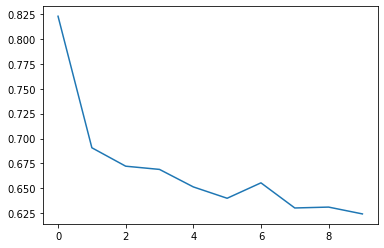

In [13]:
plt.plot(history.history['loss'])

## Evaluation of model
* Loading test data and performing normalization of those images (same condition like training images)
* Calculate and print test accuracy

In [19]:
test_dir = "./data_test"
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=test_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

test_loss, test_acc = model.evaluate(test_data_gen)
print('\nTest accuracy: ', test_acc)

Found 195 images belonging to 2 classes.


C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


7/7 [==============================] - 30s 4s/step - loss: 0.6336 - accuracy: 0.6308

Test accuracy:  0.63076925


# Plot confusion matrix (and classification report)

In [20]:
predictions = model.predict_generator(test_data_gen, test_data_gen.samples // batch_size+1)
pred = np.argmax(predictions, axis=1)

print('Confusion Matrix')
confusion = confusion_matrix(test_data_gen.classes, pred)
#print(confusion_matrix(test_data_gen.classes, pred))
print(confusion)
#plt.matshow(confusion, cmap='binary')


print('Classification Report')
target_names = ['Cars', 'E-Cars']
print(classification_report(test_data_gen.classes, pred, target_names=target_names))

Confusion Matrix
[[41 57]
 [35 62]]
Classification Report
              precision    recall  f1-score   support

        Cars       0.54      0.42      0.47        98
      E-Cars       0.52      0.64      0.57        97

    accuracy                           0.53       195
   macro avg       0.53      0.53      0.52       195
weighted avg       0.53      0.53      0.52       195



# Plot ROC and calculate AUC

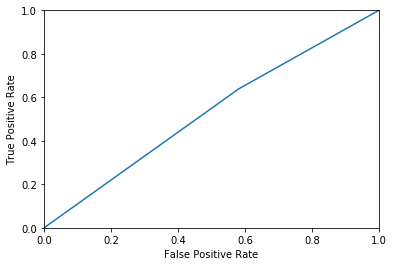

[0.         0.58163265 1.        ]
auc_score 0.5287713023353671


In [21]:
fpr , tpr , thresholds = roc_curve ( test_data_gen.classes , pred)

# function for plotting ROC curve
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  print(fpr)
    
# call function    
plot_roc_curve (fpr,tpr) 

# calculate and plot AUC
print('auc_score', roc_auc_score(test_data_gen.classes, pred))

In [ ]:
for i in np.random.choice(test_data_gen.shape[0], size=10):
    this_img = test_data_gen[i,:]
    prediction = model.predict(this_img[np.newaxis,:])
    max_class = np.argmax(prediction)
    
    plt.figure()
    plt.imshow(this_img.reshape((28,28)))
    plt.title("prediction: %d, actual: %d" %(max_class, y_test))